In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import itertools

In [3]:
rect = lambda x: (np.abs(x) <= 1/2) * 1

# 1d

## логика

In [4]:
def swap_halves(a):
    n = len(a)
    assert n % 2 == 0
    
    m = n // 2
    
    b = a
    b = np.r_[
        b[m:],
        b[:m],
    ]
    
    return b

def left_right_pad(a, m):
    n = len(a)
    
    assert n % 2 == 0
    assert m % 2 == 0
    assert m >= n
    
    l = (m - n) // 2
    r = l + n
    
    b = np.zeros(m, dtype=a.dtype)
    b[l:r] = a
    
    return b

def left_right_unpad(b, n):
    m = len(b)
    
    assert n % 2 == 0
    assert m % 2 == 0
    assert m >= n
    
    l = (m - n) // 2
    r = l + n
    
    return b[l:r]

In [5]:
def finite_fourier_1(xs1, ys1, m):
    n = len(xs1)
    assert n % 2 == 0
    assert m % 2 == 0

    a1 = xs1[-1]
    h_x1 = xs1[1] - xs1[0]

    fft_arg = ys1
    fft_arg = left_right_pad(fft_arg, m)
    fft_arg = swap_halves(fft_arg)
    
    fft_res = np.fft.fft(fft_arg)
    ys2 = fft_res * h_x1
    ys2 = swap_halves(ys2)
    ys2 = left_right_unpad(ys2, n)


    a2 = n ** 2 / (4 * a1 * m)
    xs2 = np.linspace(-a2, a2, n)
    
    return xs2, ys2

In [6]:
def finite_fourier_2(xs1, ys1, xs2):
    n = len(xs1)
    h_x1 = xs1[1] - xs1[0]
    
    # first dimension - x
    x_2d = np.broadcast_to(xs1[:, np.newaxis], (n, n))
    
    # second dimension - u
    u_2d = np.broadcast_to(xs2[np.newaxis, :], (n, n))
    
    # exp values
    A = np.exp((-2 * np.pi * 1j) * x_2d * u_2d)
    
    # scale rows by f(x)
    A = A * np.broadcast_to(ys1[:, np.newaxis], (n, n))

    int_weights = np.ones(n)
    int_weights[0] = 1/2
    int_weights[-1] = 1/2
    int_weights *= h_x1
    
    # scale rows by int_weights
    A = A * np.broadcast_to(int_weights[:, np.newaxis], (n, n))

    ys2 = np.sum(A, axis=0)
    
    return ys2

## примеры

In [41]:
f = lambda x: np.exp(-x**2)
F = lambda x: np.sqrt(np.pi) * np.exp(-x**2 * np.pi**2)

a = 5
b_given = 1.6

In [70]:
f = np.sinc
F = rect

a = 5
b_given = 1.6

In [56]:
f = lambda x: np.exp(2 * np.pi * 1j * x) + np.exp(-5 * np.pi * 1j * x)
F = lambda x: (4 * x + 3) * np.sin(8 * np.pi * x) / np.pi / (x - 1) / (2 * x + 5)

a = 1
b_given = 8

1.6


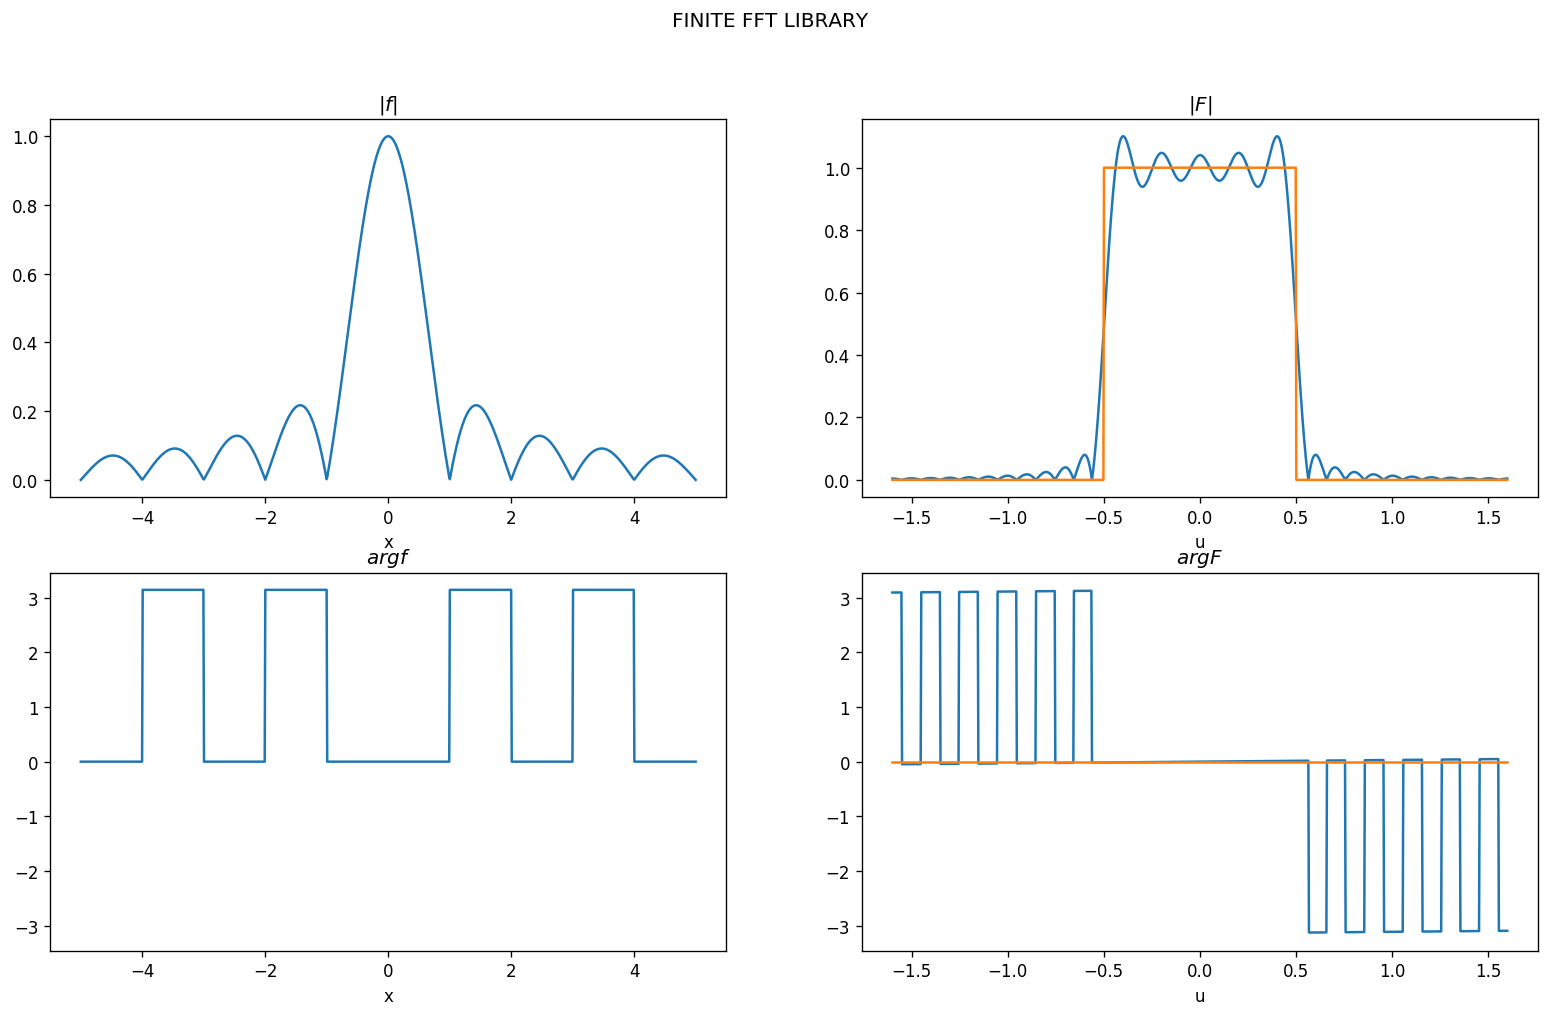

In [71]:
n = 1 << 10
m = 1 << 15

xs1 = np.linspace(-a, a, n)
ys1 = f(xs1)
ys1 = np.array(ys1, dtype=complex)

xs2, ys2 = finite_fourier_1(xs1, ys1, m)
print(xs2[-1])

ys3 = F(xs2)
ys3 = np.array(ys3, dtype=complex)

subplot(2, 2, 1)
plot(xs1, np.abs(ys1))
xlabel('x')
title('$\\left|f\\right|$')

subplot(2, 2, 3)
plot(xs1, np.angle(ys1))
ylim(-np.pi * 1.1, np.pi * 1.1)
xlabel('x')
title('$arg f$')

subplot(2, 2, 2)
plot(xs2, np.abs(ys2))
plot(xs2, np.abs(ys3))
xlabel('u')
title('$\\left|F\\right|$')

subplot(2, 2, 4)
plot(xs2, np.angle(ys2))
plot(xs2, np.angle(ys3))
ylim(-np.pi * 1.1, np.pi * 1.1)
xlabel('u')
title('$arg F$')

gcf().suptitle('FINITE FFT LIBRARY')
None

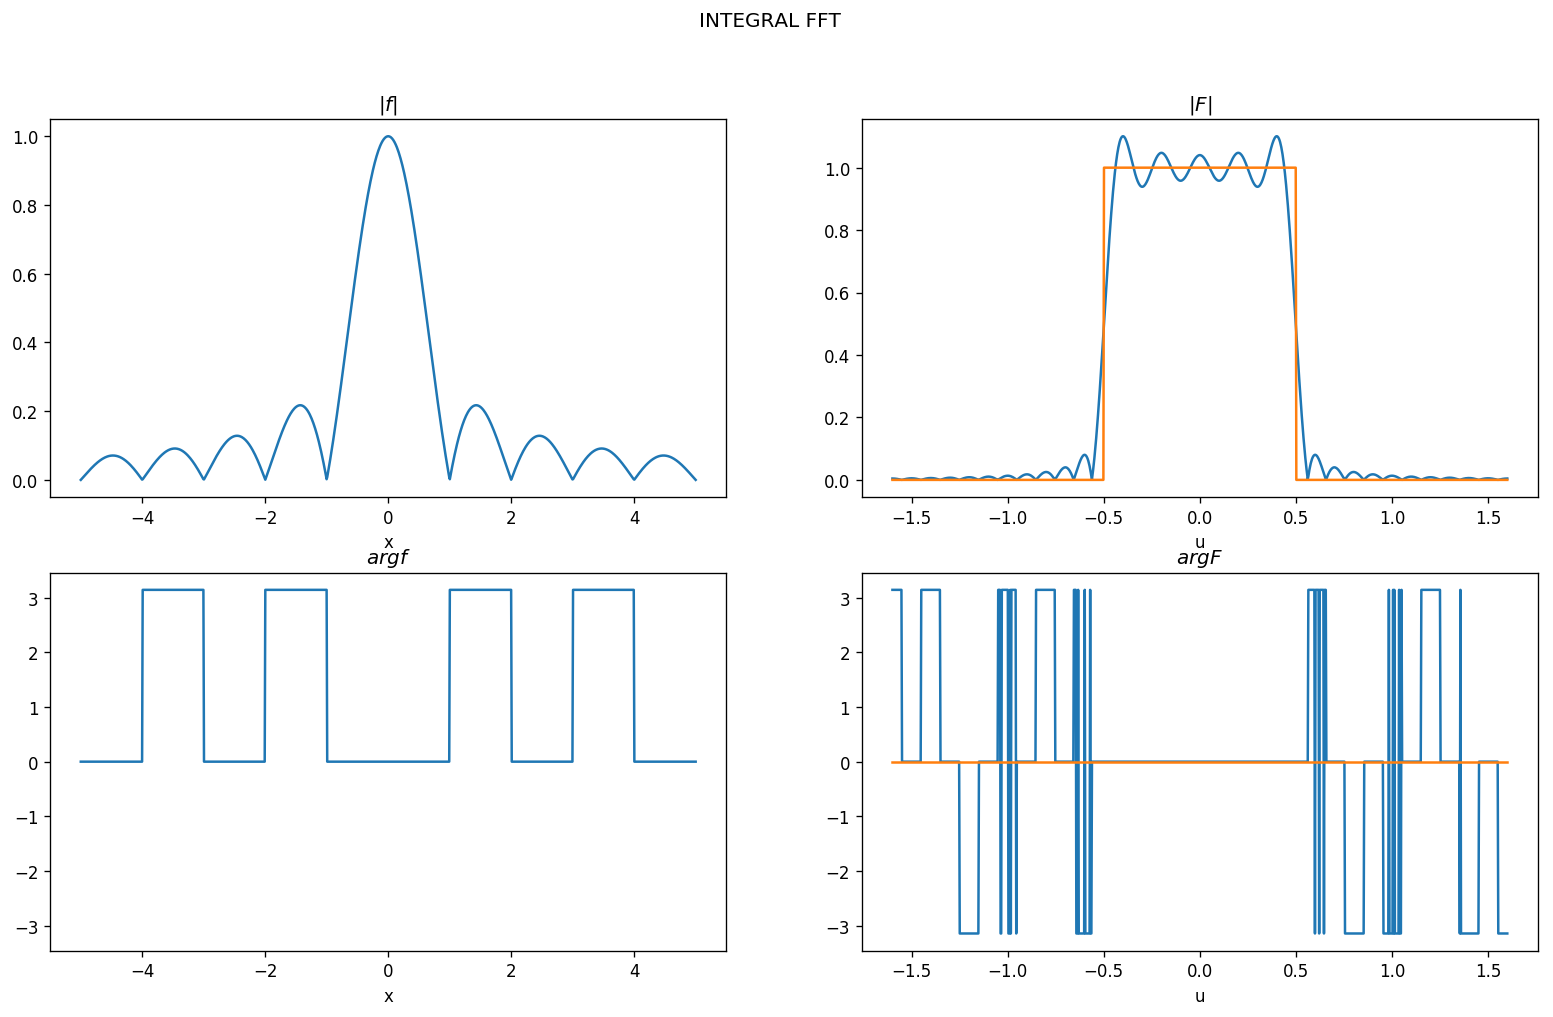

In [72]:
xs1 = np.linspace(-a, a, n)
ys1 = vectorize(f)(xs1)
ys1 = np.array(ys1, dtype=complex)

xs2 = np.linspace(-b_given, b_given, n)
ys2 = finite_fourier_2(xs1, ys1, xs2)

ys3 = F(xs2)
ys3 = np.array(ys3, dtype=complex)

subplot(2, 2, 1)
plot(xs1, np.abs(ys1))
xlabel('x')
title('$\\left|f\\right|$')

subplot(2, 2, 3)
plot(xs1, np.angle(ys1))
ylim(-np.pi * 1.1, np.pi * 1.1)
xlabel('x')
title('$arg f$')

subplot(2, 2, 2)
plot(xs2, np.abs(ys2))
plot(xs2, np.abs(ys3))
xlabel('u')
title('$\\left|F\\right|$')

subplot(2, 2, 4)
plot(xs2, np.angle(ys2))
plot(xs2, np.angle(ys3))
ylim(-np.pi * 1.1, np.pi * 1.1)
xlabel('u')
title('$arg F$')

gcf().suptitle('INTEGRAL FFT')
None

# 2d

## логика

In [10]:
def swap_halves_2d(a):
    n = len(a)
    assert n % 2 == 0
    
    m = n // 2
    
    b = a
    b = np.r_[
        b[m:, :],
        b[:m, :],
    ]
    b = np.c_[
        b[:, m:],
        b[:, :m],
    ]
    
    return b

def left_right_pad_2d(a, m):
    n = len(a)
    
    assert n % 2 == 0
    assert m % 2 == 0
    assert m >= n
    
    l = (m - n) // 2
    r = l + n
    
    b = np.zeros((m, m), dtype=a.dtype)
    b[l:r, l:r] = a
    
    return b

def left_right_unpad_2d(b, n):
    m = len(b)
    
    assert n % 2 == 0
    assert m % 2 == 0
    assert m >= n
    
    l = (m - n) // 2
    r = l + n
    
    return b[l:r, l:r]

In [11]:
def finite_fourier_1_2d(xs1, ys1, m):
    n = len(xs1)
    assert n % 2 == 0
    assert m % 2 == 0

    a1 = xs1[-1]
    h_x1 = xs1[1] - xs1[0]

    fft_arg = ys1
    fft_arg = left_right_pad_2d(fft_arg, m)
    fft_arg = swap_halves_2d(fft_arg)
    
    fft_res = np.fft.fft2(fft_arg)
    ys2 = fft_res * h_x1 * h_x1
    ys2 = swap_halves_2d(ys2)
    ys2 = left_right_unpad_2d(ys2, n)


    a2 = n ** 2 / (4 * a1 * m)
    xs2 = np.linspace(-a2, a2, n)
    
    return xs2, ys2

In [17]:
def finite_fourier_2_2d(xs1, ys1, xs2):
    n = len(xs1)
    h_x1 = xs1[1] - xs1[0]
    
    shape = (n, n, n, n)
    
    # first dimension - x
    x_4d = np.broadcast_to(xs1[:, np.newaxis, np.newaxis, np.newaxis], shape)
    # second dimension - y
    y_4d = np.broadcast_to(xs1[np.newaxis, :, np.newaxis, np.newaxis], shape)
    
    # third dimension - u
    u_4d = np.broadcast_to(xs2[np.newaxis, np.newaxis, :, np.newaxis], shape)
    # forth dimension - v
    v_4d = np.broadcast_to(xs2[np.newaxis, np.newaxis, np.newaxis, :], shape)
    
    # exp values
    A = np.exp((-2 * np.pi * 1j) * (x_4d * u_4d + y_4d * v_4d))
    
    # scale d1 and d2 by f(x, y)
    A = A * np.broadcast_to(ys1[:, :, np.newaxis, np.newaxis], shape)

    int_weights = np.ones(n)
    int_weights[0] = 1/2
    int_weights[-1] = 1/2
    int_weights *= h_x1
    
    # scale d1 by int_weights
    A = A * np.broadcast_to(int_weights[:, np.newaxis, np.newaxis, np.newaxis], shape)
    # scale d2 by int_weights
    A = A * np.broadcast_to(int_weights[np.newaxis, :, np.newaxis, np.newaxis], shape)

    A = np.sum(A, axis=0)
    A = np.sum(A, axis=0)
    
    return A

## примеры

In [36]:
f_2d = lambda a: np.exp(-(a[:, :, 0]**2 + a[:, :, 1]**2))
F_2d = lambda a: np.pi * np.exp(-(a[:, :, 0]**2 + a[:, :, 1]**2) * np.pi**2)

y1_max = 1
y2_max = np.pi

In [81]:
f_2d = lambda a: np.sinc(a[:, :, 0]) * np.sinc(a[:, :, 1])
F_2d = lambda a: rect(a[:, :, 0]) * rect(a[:, :, 1])

y1_max = 1
y2_max = 1

a = 5
b = 0.8

In [76]:
f_1d = lambda x: np.exp(2 * np.pi * 1j * x) + np.exp(-5 * np.pi * 1j * x)
F_1d = lambda x: (4 * x + 3) * np.sin(8 * np.pi * x) / np.pi / (x - 1) / (2 * x + 5)


f_2d = lambda a: f_1d(a[:, :, 0]) * f_1d(a[:, :, 1])
F_2d = lambda a: F_1d(a[:, :, 0]) * F_1d(a[:, :, 1])

y1_max = 2
y2_max = 1

a = 1
b = 4

0.8


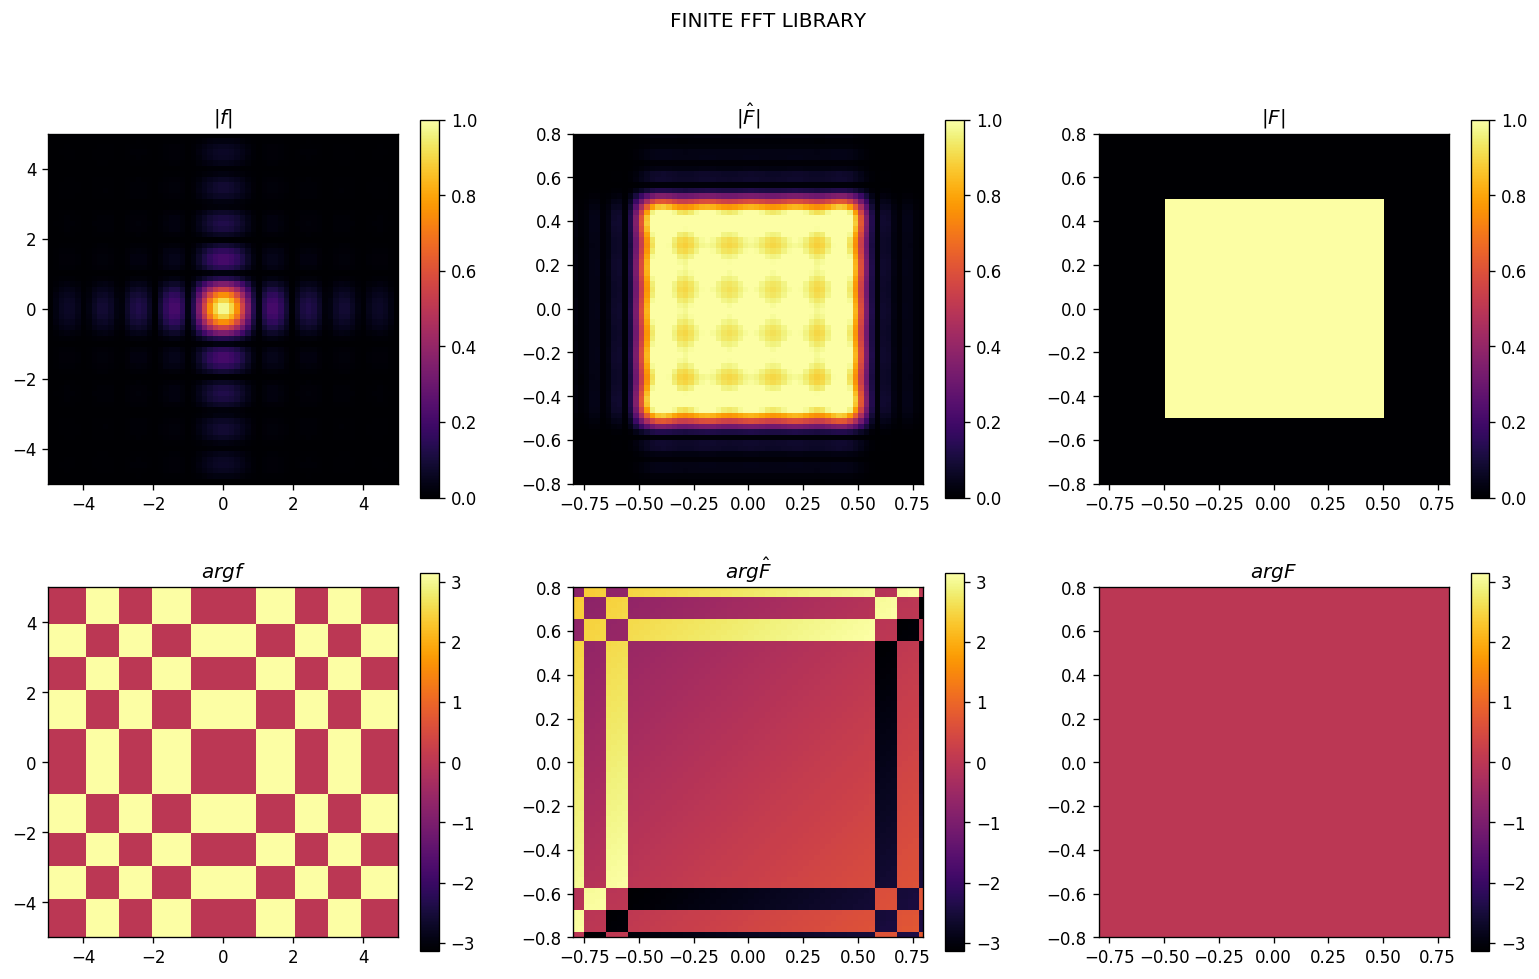

In [82]:
n = 1 << 6
m = 1 << 8

xs1 = np.linspace(-a, a, n)
X1 = np.reshape(list(itertools.product(xs1, xs1)), (n, n, 2))
ys1 = f_2d(X1)

xs2, ys2 = finite_fourier_1_2d(xs1, ys1, m)
print(xs2[-1])
X2 = np.reshape(list(itertools.product(xs2, xs2)), (n, n, 2))

ys3 = F_2d(X2)
ys3 = np.array(ys3, dtype=complex)

subplot(2, 3, 1)
imshow(
    np.abs(ys1), 
    extent=[xs1[0], xs1[-1], xs1[0], xs1[-1]],
    vmin=0,
    vmax=y1_max,
)
colorbar()
title('$\\left|f\\right|$')

subplot(2, 3, 4)
imshow(
    np.angle(ys1),
    extent=[xs1[0], xs1[-1], xs1[0], xs1[-1]],
    vmin=-np.pi, 
    vmax=np.pi,
)
colorbar()
title('$arg f$')

subplot(2, 3, 2)
imshow(
    np.abs(ys2), 
    extent=[xs2[0], xs2[-1], xs2[0], xs2[-1]],
    vmin=0,
    vmax=y2_max,
)
colorbar()
title('$\\left|\hat F\\right|$')

subplot(2, 3, 5)
imshow(
    np.angle(ys2), 
    extent=[xs2[0], xs2[-1], xs2[0], xs2[-1]],
    vmin=-np.pi, 
    vmax=np.pi,
)
colorbar()
title('$arg \hat F$')

subplot(2, 3, 3)
imshow(
    np.abs(ys3), 
    extent=[xs2[0], xs2[-1], xs2[0], xs2[-1]],
    vmin=0,
    vmax=y2_max,
)
colorbar()
title('$\\left|F\\right|$')

subplot(2, 3, 6)
imshow(
    np.angle(ys3), 
    extent=[xs2[0], xs2[-1], xs2[0], xs2[-1]],
    vmin=-np.pi, 
    vmax=np.pi,
)
colorbar()
title('$arg F$')

gcf().suptitle('FINITE FFT LIBRARY')
None

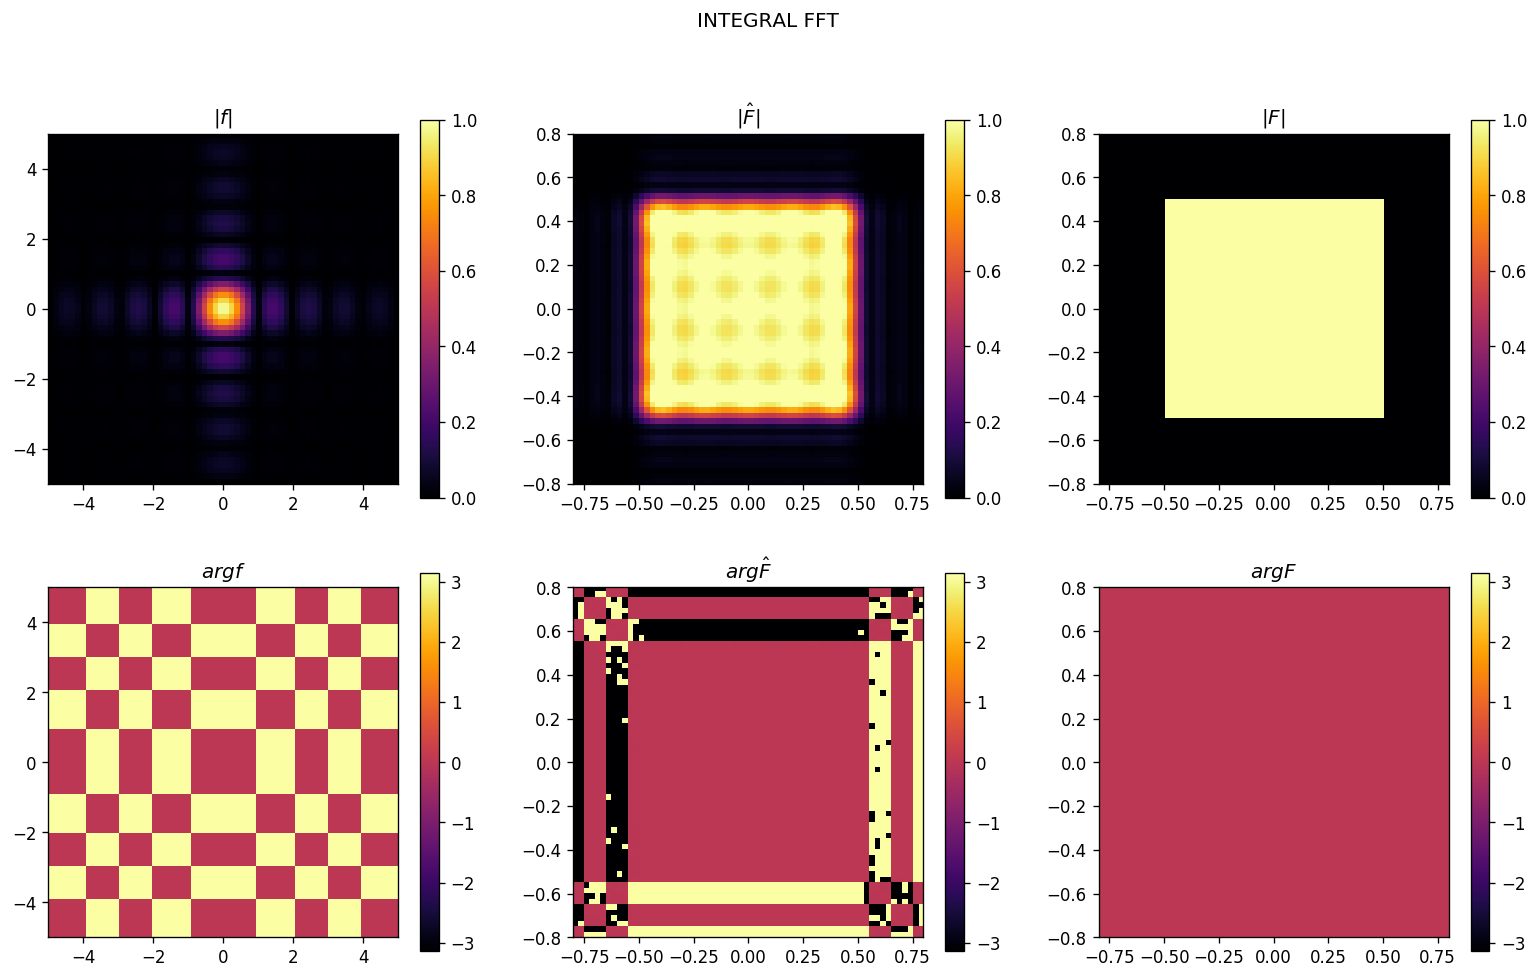

In [83]:
n = 1 << 6

xs1 = np.linspace(-a, a, n)
X1 = np.reshape(list(itertools.product(xs1, xs1)), (n, n, 2))
ys1 = f_2d(X1)

xs2 = np.linspace(-b, b, n)
ys2 = finite_fourier_2_2d(xs1, ys1, xs2)

ys3 = F_2d(X2)
ys3 = np.array(ys3, dtype=complex)

subplot(2, 3, 1)
imshow(
    np.abs(ys1), 
    extent=[xs1[0], xs1[-1], xs1[0], xs1[-1]],
    vmin=0,
    vmax=y1_max,
)
colorbar()
title('$\\left|f\\right|$')

subplot(2, 3, 4)
imshow(
    np.angle(ys1),
    extent=[xs1[0], xs1[-1], xs1[0], xs1[-1]],
    vmin=-np.pi, 
    vmax=np.pi,
)
colorbar()
title('$arg f$')

subplot(2, 3, 2)
imshow(
    np.abs(ys2), 
    extent=[xs2[0], xs2[-1], xs2[0], xs2[-1]],
    vmin=0,
    vmax=y2_max,
)
colorbar()
title('$\\left|\hat F\\right|$')

subplot(2, 3, 5)
imshow(
    np.angle(ys2), 
    extent=[xs2[0], xs2[-1], xs2[0], xs2[-1]],
    vmin=-np.pi, 
    vmax=np.pi,
)
colorbar()
title('$arg \hat F$')

subplot(2, 3, 3)
imshow(
    np.abs(ys3), 
    extent=[xs2[0], xs2[-1], xs2[0], xs2[-1]],
    vmin=0,
    vmax=y2_max,
)
colorbar()
title('$\\left|F\\right|$')

subplot(2, 3, 6)
imshow(
    np.angle(ys3), 
    extent=[xs2[0], xs2[-1], xs2[0], xs2[-1]],
    vmin=-np.pi, 
    vmax=np.pi,
)
colorbar()
title('$arg F$')

gcf().suptitle('INTEGRAL FFT')
None